# Importing Libraries

In [2]:
%load_ext autoreload
%autoreload

In [3]:
import os
import torch
import numpy as np
import math
from functools import partial
import torch
import torch.nn as nn

import ipywidgets as widgets
import io
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, einsum

import warnings
warnings.filterwarnings("ignore")

from utils.drop_path import DropPath
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from models.gmm import Gaussian_Mixture_Mask, Simple_Mask, On_attention_gaussian_mask

import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Vision Transformer

In [4]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
class PreNorm(nn.Module):
    def __init__(self, num_tokens, dim, fn):
        super().__init__()
        self.dim = dim
        self.num_tokens = num_tokens
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), ** kwargs)
 
class FeedForward(nn.Module):
    def __init__(self, dim, num_patches, hidden_dim, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_patches = num_patches
        
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )            
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, num_patches, heads = 8, dim_head = 64, dropout = 0., is_GMM=False, is_SLM=False, num_kernals=3, mask=None):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
        self.num_kernals = num_kernals
        self.num_patches = num_patches
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.dim = dim
        self.inner_dim = inner_dim
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(self.dim, self.inner_dim * 3, bias = False)
        init_weights(self.to_qkv)
        self.to_out = nn.Sequential(
            nn.Linear(self.inner_dim, self.dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
            
        if is_GMM:
            self.mask = Gaussian_Mixture_Mask(num_heads=self.heads, num_kernals=num_kernals, mask=mask)
        elif is_SLM:
            self.mask = Simple_Mask(num_heads=self.heads, num_patches=self.num_patches)
        else:
            self.mask = None

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        
        if self.mask is not None:
            dots = self.mask(dots)
        
        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v) 
            
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out), attn
    
    def flops(self):
        flops = 0
        if not self.is_coord:
            flops += self.dim * self.inner_dim * 3 * (self.num_patches+1)
        else:
            flops += (self.dim+2) * self.inner_dim * 3 * self.num_patches  
            flops += self.dim * self.inner_dim * 3  


class Transformer(nn.Module):
    def __init__(self, dim, num_patches, depth, heads, dim_head, mlp_dim_ratio, num_kernals, dropout = 0., stochastic_depth=0., is_GMM=False, is_SLM=False, mask=None,):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.scale = {}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(num_patches, dim, Attention(dim, num_patches, heads = heads, dim_head = dim_head, dropout = dropout, is_GMM=is_GMM, is_SLM=is_SLM, num_kernals = num_kernals, mask=mask)),
                PreNorm(num_patches, dim, FeedForward(dim, num_patches, dim * mlp_dim_ratio, dropout = dropout))
            ]))            
        self.drop_path = DropPath(stochastic_depth) if stochastic_depth > 0 else nn.Identity()
    
    def forward(self, x, return_attn=False):
        for i, (attn, ff) in enumerate(self.layers):      
            y, attn_score = attn(x)
            if return_attn:
                if i < len(self.layers) - 1:
                    x = self.drop_path(y) + x
                    x = self.drop_path(ff(x)) + x            
                    self.scale[str(i)] = attn.fn.scale
                else:
                    # return attention of the last block
                    return attn_score
            else:
                x = self.drop_path(y) + x
                x = self.drop_path(ff(x)) + x            
                self.scale[str(i)] = attn.fn.scale
        return x

class ViT(nn.Module):
    def __init__(self, *, img_size, patch_size, num_classes, dim, depth, heads, mlp_dim_ratio, num_kernals, channels = 3, 
                 dim_head = 16, dropout = 0., emb_dropout = 0., stochastic_depth=0., is_GMM=False ,is_SLM=False,):
        super().__init__()
        image_height, image_width = pair(img_size)
        patch_height, patch_width = pair(patch_size)
        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_dim = channels * patch_height * patch_width
        self.dim = dim
        self.num_classes = num_classes

        self.mask = nn.Parameter(On_attention_gaussian_mask(self.num_patches), requires_grad=False)

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(self.patch_dim, self.dim)
        )
            
         
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, self.dim))
            
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(self.dim, self.num_patches, depth, heads, dim_head, mlp_dim_ratio, num_kernals, dropout, 
                                       stochastic_depth, is_GMM=is_GMM, is_SLM=is_SLM, mask=self.mask)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.dim),
            nn.Linear(self.dim, self.num_classes)
        )
        
        self.apply(init_weights)

    def forward(self, img):
        # patch embedding
        
        x = self.to_patch_embedding(img)
            
        b, n, _ = x.shape
        
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)      
        
        return self.mlp_head(x.mean(dim=1))
    
    def get_last_selfattention(self, img):
        
        x = self.to_patch_embedding(img)
            
        b, n, _ = x.shape
        
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x, return_attn=True)      
        
        return x


In [5]:
def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img


def visualize_predict(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device)).detach()

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions.mean(dim=2).reshape(nh, -1)
    # attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()



In [6]:
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()
    
    return heatmap, result

# main

In [7]:
checkpoint1_path = 'save/vit-heat-Base--T-IMNET-LR[0.001]-Seed0/best.pth'
is_GMM_1 = False
is_SLM_1 = False
patch_size = 4

In [8]:
checkpoint2_path = 'save/vit-heat-SLM--T-IMNET-LR[0.001]-Seed0/best.pth'
is_GMM_2 = False
is_SLM_2 = True
patch_size = 4

In [9]:
checkpoint3_path = 'save/vit-heat-GMMn5--T-IMNET-LR[0.001]-Seed0/best.pth'
is_GMM_3 = True
is_SLM_3 = False
patch_size = 4

In [10]:
model1 = ViT(img_size=64, patch_size = patch_size, num_classes=200, dim=192, 
                    mlp_dim_ratio=2, depth=8, heads=6, dim_head=192//6,
                    stochastic_depth=0.1, is_GMM=is_GMM_1, is_SLM=is_SLM_1, num_kernals=5)

checkpoint1 = torch.load(checkpoint1_path)
model1.load_state_dict(checkpoint1['model_state_dict'])

<All keys matched successfully>

In [11]:
model2 = ViT(img_size=64, patch_size = patch_size, num_classes=200, dim=192, 
                    mlp_dim_ratio=2, depth=8, heads=6, dim_head=192//6,
                    stochastic_depth=0.1, is_GMM=is_GMM_2, is_SLM=is_SLM_2, num_kernals=5)

checkpoint2 = torch.load(checkpoint2_path)
model2.load_state_dict(checkpoint2['model_state_dict'])

<All keys matched successfully>

In [12]:
model3 = ViT(img_size=64, patch_size = patch_size, num_classes=200, dim=192, 
                    mlp_dim_ratio=2, depth=8, heads=6, dim_head=192//6,
                    stochastic_depth=0.1, is_GMM=is_GMM_3, is_SLM=is_SLM_3, num_kernals=5)

checkpoint3 = torch.load(checkpoint3_path)
model3.load_state_dict(checkpoint3['model_state_dict'])

<All keys matched successfully>

In [ ]:
for i in [15, 18, 129, 245, 415, 420, 668, 1030, 1043, 1088, 1294, 1310, 1467, 2191, 2374]:
    val_dataset = datasets.ImageFolder(
                root='dataset/tiny_imagenet/val')
    
    img = val_dataset[i][0]
    
    transform = transforms.Compose([
                transforms.Resize(64), transforms.ToTensor(), 
                transforms.Normalize(mean=(0.4802, 0.4481, 0.3975), std=(0.2770, 0.2691, 0.2821))
                ])
    attention1 = visualize_attention(model1, transform(img), patch_size, 'cpu')
    attention2 = visualize_attention(model2, transform(img), patch_size, 'cpu')
    attention3 = visualize_attention(model3, transform(img), patch_size, 'cpu')

    plt.figure(figsize=(10, 10))
    text = str(i)
    plt.subplot(5, 4, 1)
    plt.axis('off')
    plt.imshow(img, cmap='inferno')
    # plt.title(text)
    plt.subplot(5, 4, 2)
    plt.axis('off')
    plt.imshow(np.mean(attention1, 0), cmap='inferno', interpolation='gaussian')
    plt.subplot(5, 4, 3)
    plt.axis('off')
    plt.imshow(np.mean(attention2, 0), cmap='inferno', interpolation='gaussian')
    plt.subplot(5, 4, 4)
    plt.axis('off')
    plt.imshow(np.mean(attention3, 0), cmap='inferno', interpolation='gaussian')
    plt.savefig('save_img/'+text+'.png')

In [ ]:
j=0
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace =0.1, hspace =0.1)
for i in [15, 18, 129, 245, 415]:
    
    val_dataset = datasets.ImageFolder(
                root='dataset/tiny_imagenet/val')
    
    img = val_dataset[i][0]
    
    transform = transforms.Compose([
                transforms.Resize(64), transforms.ToTensor(), 
                transforms.Normalize(mean=(0.4802, 0.4481, 0.3975), std=(0.2770, 0.2691, 0.2821))
                ])
    attention1 = visualize_attention(model1, transform(img), patch_size, 'cpu')
    attention2 = visualize_attention(model2, transform(img), patch_size, 'cpu')
    attention3 = visualize_attention(model3, transform(img), patch_size, 'cpu')

    text = str(i)
    plt.subplot(5, 4, j+1)
    plt.axis('off')
    plt.imshow(img, cmap='inferno')
    # plt.title(text)
    plt.subplot(5, 4, j+2)
    plt.axis('off')
    plt.imshow(np.mean(attention1, 0), cmap='inferno', interpolation='gaussian')
    plt.subplot(5, 4, j+3)
    plt.axis('off')
    plt.imshow(np.mean(attention2, 0), cmap='inferno', interpolation='gaussian')
    plt.subplot(5, 4, j+4)
    plt.axis('off')
    plt.imshow(np.mean(attention3, 0), cmap='inferno', interpolation='gaussian')
    j+=4
    
plt.savefig('1_lie.png')

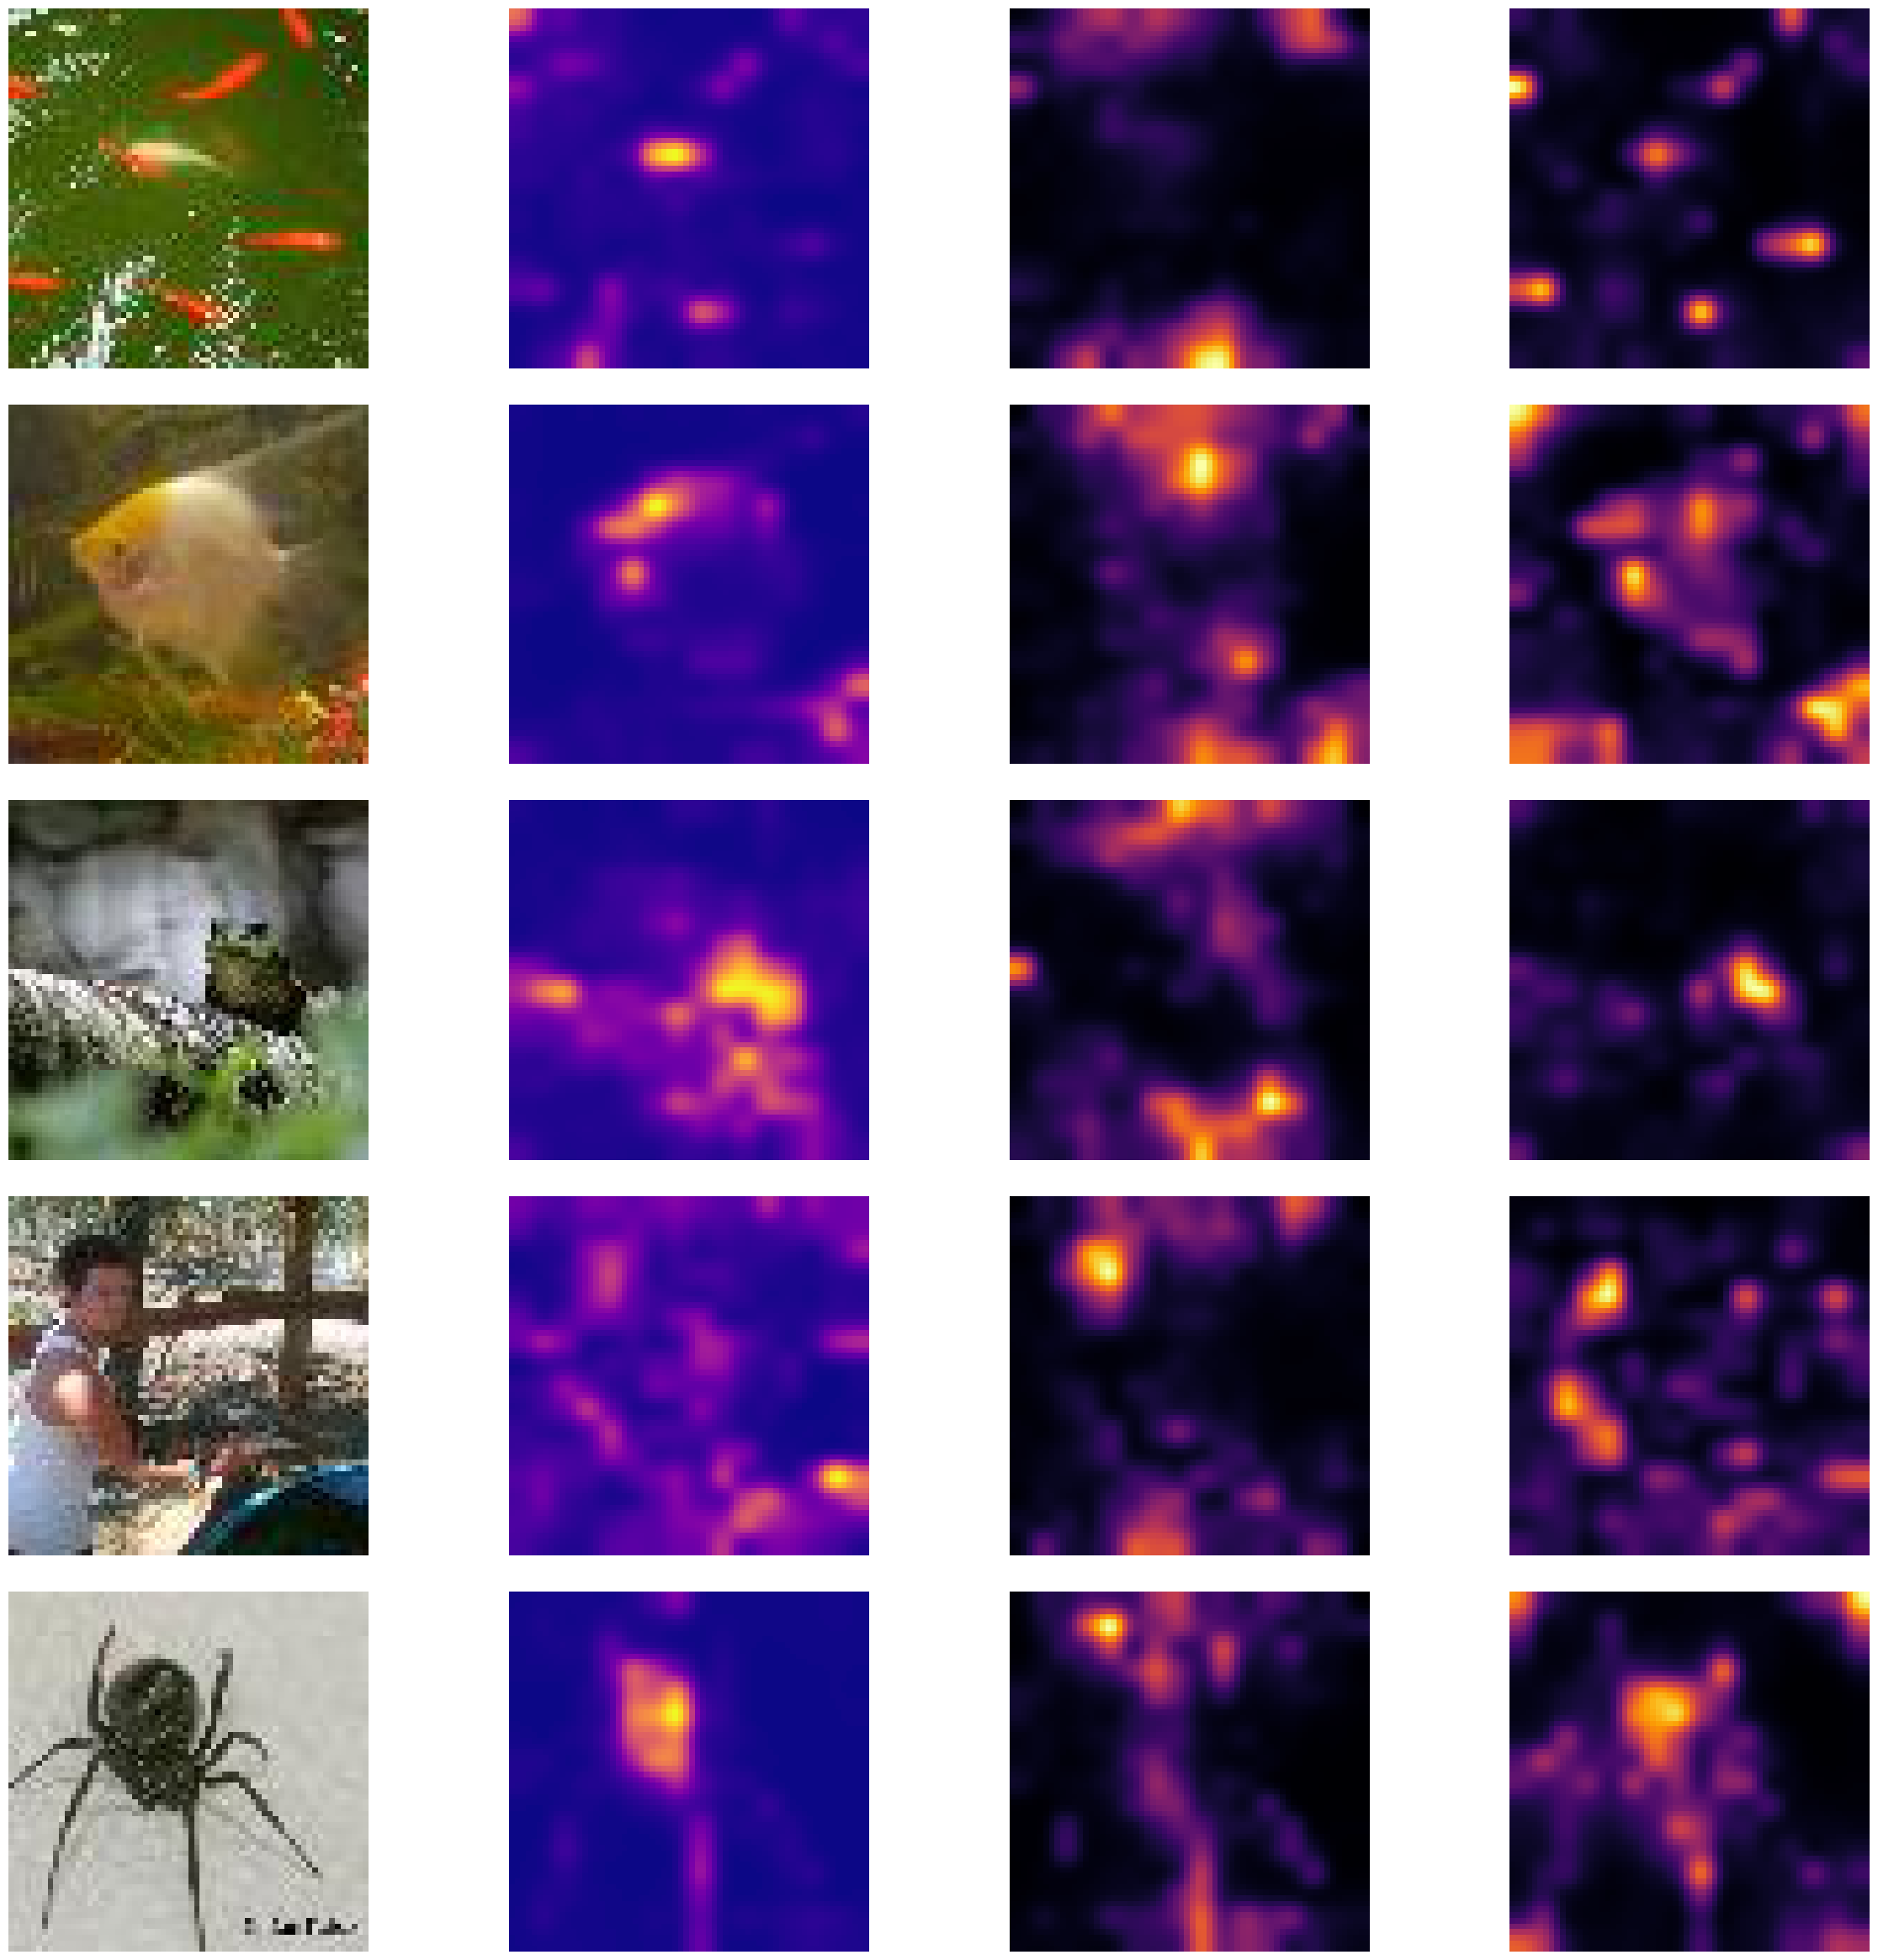

In [74]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

j = 0
plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in [15, 18, 129, 245, 415]:
    val_dataset = datasets.ImageFolder(root='dataset/tiny_imagenet/val')
    img = val_dataset[i][0]

    transform = transforms.Compose([
        transforms.Resize(64), transforms.ToTensor(),
        transforms.Normalize(mean=(0.4802, 0.4481, 0.3975), std=(0.2770, 0.2691, 0.2821))
    ])

    attention1 = visualize_attention(model1, transform(img), patch_size, 'cpu')
    attention2 = visualize_attention(model2, transform(img), patch_size, 'cpu')
    attention3 = visualize_attention(model3, transform(img), patch_size, 'cpu')

    text = str(i)

    plt.subplot(5, 4, j + 1)
    plt.axis('off')
    plt.imshow(img, cmap='inferno')
    # plt.title(text)

    sigma = 1.5

    plt.subplot(5, 4, j + 2)
    plt.axis('off')
    plt.imshow(gaussian_filter(np.mean(attention1, 0), sigma=sigma), cmap='plasma')

    plt.subplot(5, 4, j + 3)
    plt.axis('off')
    plt.imshow(gaussian_filter(np.mean(attention2, 0), sigma=sigma), cmap='inferno')

    plt.subplot(5, 4, j + 4)
    plt.axis('off')
    plt.imshow(gaussian_filter(np.mean(attention3, 0), sigma=sigma), cmap='inferno')

    j += 4

plt.savefig('1_lie.png')

# Resize the saved image
image = Image.open('1_lie.png')
resized_image = image.resize((image.width * 4, image.height * 4), resample=Image.BICUBIC)


In [ ]:
i = 13

val_dataset = datasets.ImageFolder(
            root='dataset/tiny_imagenet/val')

img = val_dataset[i][0]

transform = transforms.Compose([
            transforms.Resize(64), transforms.ToTensor(), 
            # transforms.Normalize(mean=(0.4802, 0.4481, 0.3975), std=(0.2770, 0.2691, 0.2821))
            ])

attention1 = visualize_attention(model1, transform(img), patch_size, 'cpu')
attention2 = visualize_attention(model2, transform(img), patch_size, 'cpu')
attention3 = visualize_attention(model3, transform(img), patch_size, 'cpu')

mask1 = torch.from_numpy(np.mean(attention1, 0)).view(1, 1, 64, 64)
image = transform(img).view(1, 3, 64, 64)

max_mask1, min_mask1 = mask1.max(), mask1.min()
max_image, min_image = image.max(), image.min()

mask1 = (mask1 - min_mask1)/(max_mask1 - min_mask1)
image = (image - min_image)/(max_image - min_image)

mask1 = torch.from_numpy(np.mean(attention1, 0)).view(1, 1, 64, 64)

image = transform(img).view(1, 3, 64, 64)

import cv2
heatmap1, result1 = visualize_cam(mask1, image)

# 将张量转换为NumPy数组并重新排列通道顺序
heatmap1_np = heatmap1.permute(1, 2, 0).numpy()
result1_np = result1.permute(1, 2, 0).numpy()
image_np = image.view(64, 64, 3).numpy()

# 创建一个具有两个子图的图形对象
fig, axes = plt.subplots(1, 3)

# 在第一个子图中显示heatmap1
axes[0].imshow(heatmap1_np)
axes[0].set_title('Heatmap 1')

# 在第二个子图中显示result1
axes[1].imshow(result1_np)
axes[1].set_title('Result 1')

axes[2].imshow(img)
axes[2].set_title('image')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [ ]:
plot_attention(img, attention1)

In [ ]:
plot_attention(img, attention2)

In [ ]:
plot_attention(img, attention3)

In [ ]:
n_heads = attention.shape[0]

plt.figure(figsize=(10, 10))
text = ["Original Image", "Head Mean"]
for i, fig in enumerate([img, np.mean(attention, 0)]):
    plt.subplot(1, 2, i+1)
    plt.imshow(fig, cmap='inferno')
    plt.title(text[i])
plt.show()

plt.figure(figsize=(10, 10))
for i in range(n_heads):
    plt.subplot(n_heads//3, 3, i+1)
    plt.imshow(attention[i], cmap='inferno')
    plt.title(f"Head n: {i+1}")
plt.tight_layout()
plt.show()

In [153]:
# zhe xian tu

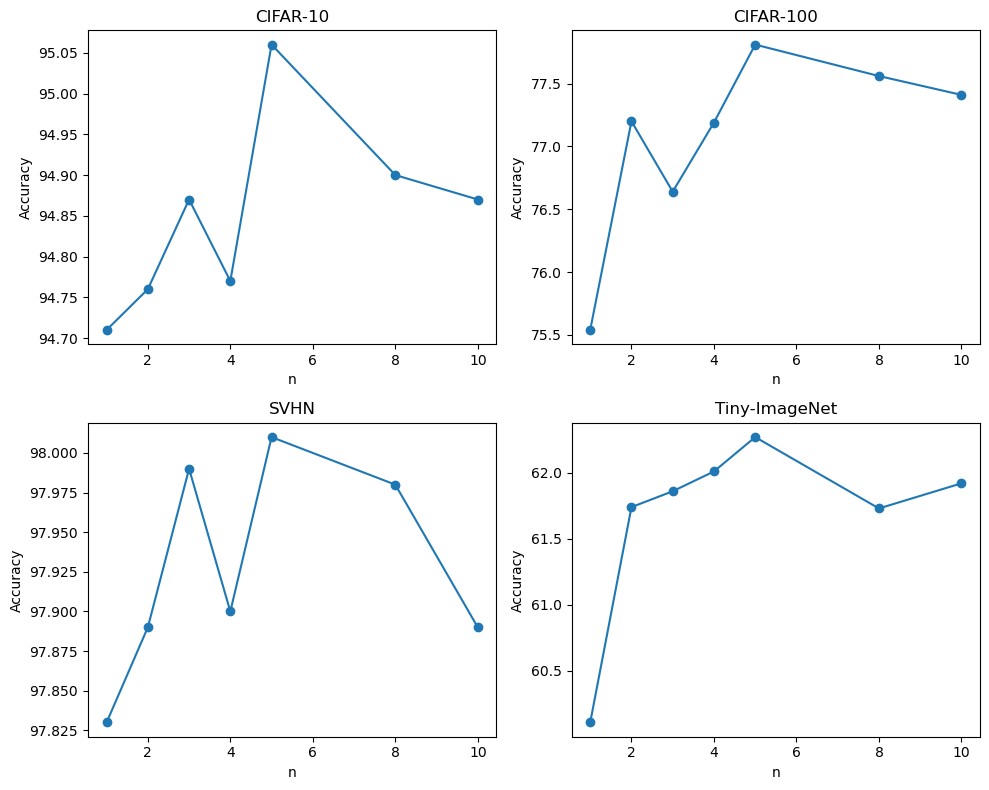

In [154]:
import matplotlib.pyplot as plt

# 数据
n_values = [1, 2, 3, 4, 5, 8, 10]
cifar10_acc = [94.71, 94.76, 94.87, 94.95, 95.06, 94.90, 94.87]
cifar100_acc = [75.54, 77.20, 76.64, 77.19, 77.81, 77.56, 77.41]
svhn_acc = [97.83, 97.89, 97.99, 97.90, 98.01, 97.98, 97.89]
tiny_imagenet_acc = [60.11, 61.74, 61.86, 62.01, 62.27, 61.73, 61.92]

# 绘制四个数据集的折线图
plt.figure(figsize=(10, 8))

# CIFAR-10
plt.subplot(2, 2, 1)
plt.plot(n_values, cifar10_acc, marker='o')
plt.title('CIFAR-10')
plt.xlabel('n')
plt.ylabel('Accuracy')

# CIFAR-100
plt.subplot(2, 2, 2)
plt.plot(n_values, cifar100_acc, marker='o')
plt.title('CIFAR-100')
plt.xlabel('n')
plt.ylabel('Accuracy')

# SVHN
plt.subplot(2, 2, 3)
plt.plot(n_values, svhn_acc, marker='o')
plt.title('SVHN')
plt.xlabel('n')
plt.ylabel('Accuracy')

# Tiny-ImageNet
plt.subplot(2, 2, 4)
plt.plot(n_values, tiny_imagenet_acc, marker='o')
plt.title('Tiny-ImageNet')
plt.xlabel('n')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

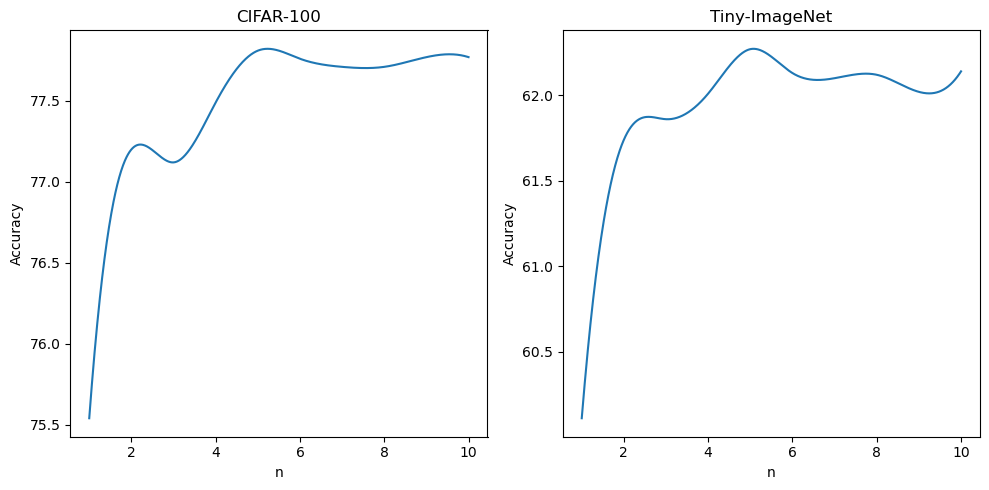

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 数据
n_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cifar100_acc = np.array([75.54, 77.20, 77.12, 77.49, 77.81, 77.76, 77.71, 77.71, 77.77, 77.77])
tiny_imagenet_acc = np.array([60.11, 61.74, 61.86, 62.01, 62.27, 62.13, 62.10, 62.12, 62.02, 62.14])

# 插值
n_smooth = np.linspace(n_values.min(), n_values.max(), 1000)
cifar100_acc_smooth = interp1d(n_values, cifar100_acc, kind='cubic')(n_smooth)
tiny_imagenet_acc_smooth = interp1d(n_values, tiny_imagenet_acc, kind='cubic')(n_smooth)

# 绘制两个数据集的折线图
plt.figure(figsize=(10, 5))

# CIFAR-100
plt.subplot(1, 2, 1)
plt.plot(n_smooth, cifar100_acc_smooth)
plt.title('CIFAR-100')
plt.xlabel('n')
plt.ylabel('Accuracy')

# Tiny-ImageNet
plt.subplot(1, 2, 2)
plt.plot(n_smooth, tiny_imagenet_acc_smooth)
plt.title('Tiny-ImageNet')
plt.xlabel('n')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('figs/line_plots.png', dpi=300)
plt.show()

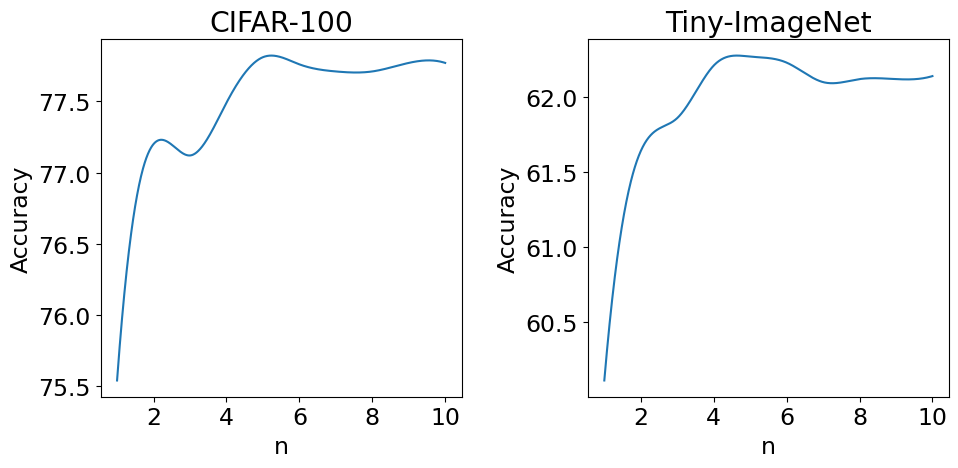

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 数据
n_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cifar100_acc = np.array([75.54, 77.20, 77.12, 77.49, 77.81, 77.76, 77.71, 77.71, 77.77, 77.77])
tiny_imagenet_acc = np.array([60.11, 61.64, 61.86, 62.21, 62.27, 62.23, 62.10, 62.12, 62.12, 62.14])

# 插值
n_smooth = np.linspace(n_values.min(), n_values.max(), 1000)
cifar100_acc_smooth = interp1d(n_values, cifar100_acc, kind='cubic')(n_smooth)
tiny_imagenet_acc_smooth = interp1d(n_values, tiny_imagenet_acc, kind='cubic')(n_smooth)

# 调整字号
plt.rcParams.update({'font.size': 17})

# 绘制两个数据集的折线图
plt.figure(figsize=(10, 5))

# CIFAR-100
plt.subplot(1, 2, 1)
plt.plot(n_smooth, cifar100_acc_smooth)
plt.title('CIFAR-100')
plt.xlabel('n')
plt.ylabel('Accuracy')

# Tiny-ImageNet
plt.subplot(1, 2, 2)
plt.plot(n_smooth, tiny_imagenet_acc_smooth)
plt.title('Tiny-ImageNet')
plt.xlabel('n')
plt.ylabel('Accuracy')

plt.tight_layout()

# 保存图像
plt.savefig('line_plots.png', dpi=300)

plt.show()


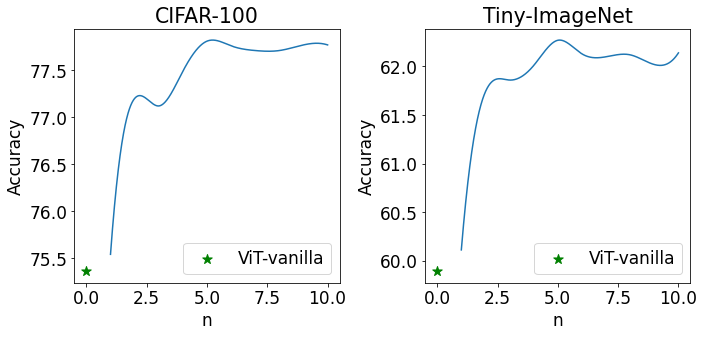

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 数据
n_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cifar100_acc = np.array([75.54, 77.20, 77.12, 77.49, 77.81, 77.76, 77.71, 77.71, 77.77, 77.77])
tiny_imagenet_acc = np.array([60.11, 61.74, 61.86, 62.01, 62.27, 62.13, 62.10, 62.12, 62.02, 62.14])

# 插值
n_smooth = np.linspace(n_values.min(), n_values.max(), 1000)
cifar100_acc_smooth = interp1d(n_values, cifar100_acc, kind='cubic')(n_smooth)
tiny_imagenet_acc_smooth = interp1d(n_values, tiny_imagenet_acc, kind='cubic')(n_smooth)

# 调整字号
plt.rcParams.update({'font.size': 17})

# 绘制两个数据集的折线图
plt.figure(figsize=(10, 5))

# CIFAR-100
plt.subplot(1, 2, 1)
plt.plot(n_smooth, cifar100_acc_smooth)
plt.scatter(0, 75.36, color='green', label='ViT-vanilla', marker='*', s=100)
plt.title('CIFAR-100')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.legend()

# Tiny-ImageNet
plt.subplot(1, 2, 2)
plt.plot(n_smooth, tiny_imagenet_acc_smooth)
plt.scatter(0, 59.89, color='green', label='ViT-vanilla', marker='*', s=100)
plt.title('Tiny-ImageNet')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figs/line_plots.png', dpi=300)
plt.show()


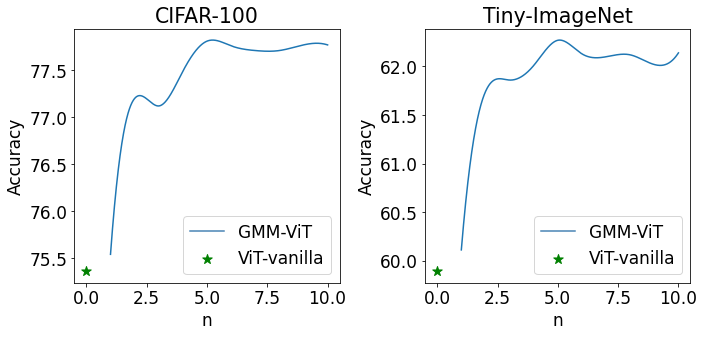

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 数据
n_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cifar100_acc = np.array([75.54, 77.20, 77.12, 77.49, 77.81, 77.76, 77.71, 77.71, 77.77, 77.77])
tiny_imagenet_acc = np.array([60.11, 61.74, 61.86, 62.01, 62.27, 62.13, 62.10, 62.12, 62.02, 62.14])

# 插值
n_smooth = np.linspace(n_values.min(), n_values.max(), 1000)
cifar100_acc_smooth = interp1d(n_values, cifar100_acc, kind='cubic')(n_smooth)
tiny_imagenet_acc_smooth = interp1d(n_values, tiny_imagenet_acc, kind='cubic')(n_smooth)

# 调整字号
plt.rcParams.update({'font.size': 17})

# 绘制两个数据集的折线图
plt.figure(figsize=(10, 5))

# CIFAR-100
plt.subplot(1, 2, 1)
plt.plot(n_smooth, cifar100_acc_smooth)
plt.scatter(0, 75.36, color='green', label='ViT-vanilla', marker='*', s=100)
plt.plot([], [], color='steelblue', label='GMM-ViT')  # 添加一个空的plot来显示标签
plt.title('CIFAR-100')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.legend()

# Tiny-ImageNet
plt.subplot(1, 2, 2)
plt.plot(n_smooth, tiny_imagenet_acc_smooth)
plt.scatter(0, 59.89, color='green', label='ViT-vanilla', marker='*', s=100)
plt.plot([], [], color='steelblue', label='GMM-ViT')  # 添加一个空的plot来显示标签
plt.title('Tiny-ImageNet')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figs/line_plots.png', dpi=300)
plt.show()


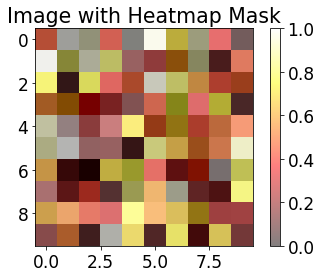

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例图像数据
image = np.random.rand(10, 10)

# 生成示例热力图掩膜数据
mask = np.random.rand(10, 10)

# 创建图形对象和子图对象
fig, ax = plt.subplots()

# 绘制图像
ax.imshow(image, cmap='gray')

# 绘制热力图掩膜
heatmap = ax.imshow(mask, cmap='hot', alpha=0.5)

# 设置热力图的颜色范围
heatmap.set_clim(vmin=0, vmax=1)

# 添加颜色栏
cbar = plt.colorbar(heatmap)

# 设置图形标题
ax.set_title('Image with Heatmap Mask')

# 显示图形
plt.show()
